In [0]:
# 因為圖片實在太多，所以要用壓縮檔載入

import zipfile
f = zipfile.ZipFile("drive/My Drive/train.zip")
f.extractall("./datasets")

In [2]:
import glob

catfs = glob.glob("./datasets/train/cat.*.jpg")

print(catfs[0])
len(catfs)

./datasets/train/cat.5220.jpg


12500

In [3]:
import glob
import pandas as pd

# cat = 0
catfs = glob.glob("datasets/train/cat.*.jpg")
catans = [0] * len(catfs)

# dog = 1
dogfs = glob.glob("datasets/train/dog.*.jpg")
dogans = [1] * len(dogfs)

# 製作表格
df = pd.DataFrame({
    "path":catfs + dogfs,
    "target":catans + dogans
})

df

,path,target
0,datasets/train/cat.5220.jpg,0
1,datasets/train/cat.8645.jpg,0
2,datasets/train/cat.9528.jpg,0
3,datasets/train/cat.8257.jpg,0
4,datasets/train/cat.8414.jpg,0
...,...,...
24995,datasets/train/dog.716.jpg,1
24996,datasets/train/dog.10747.jpg,1
24997,datasets/train/dog.11795.jpg,1
24998,datasets/train/dog.2455.jpg,1


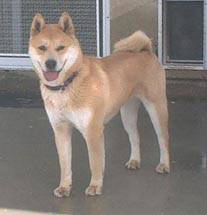

In [4]:
# 看一下

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.image import load_img
import random

idx = random.randint(0, 25000)
img = load_img(df["path"][idx])

img

In [5]:
# cnn = VGG16

from tensorflow.keras.applications.vgg16 import VGG16

# 輸入照片不一樣大
# 所以要改長寬

# include_top = MLP = 關掉VGG16的MLP，後面在自己加。
# 所有照片改成 input_shape = (224, 224, 3) 的大小輸入。
cnn = VGG16(include_top=False, input_shape=(224, 224, 3))

cnn.layers

In [0]:
# Ver. Sequential

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization

model = Sequential()

for l in cnn.layers:
  # !!! trainable一定要先設置
  # !!! VGG16的權重我不想改變他
  l.trainable = False
  model.add(l)

# 這邊的權重我想改變他
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dense(2, activation = "softmax"))

# model.summary()

In [7]:
# Ver. Model

from tensorflow.keras.models import Model

for l in cnn.layers:
  # !!! trainable一定要先設置
  # !!! VGG16的權重我不想改變他
  l.trainable = False

# BatchNormalization() 一定要放在 Flatten() 前面
x = BatchNormalization()(cnn.output)
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
out = Dense(2, activation="softmax")(x)

model2 = Model(inputs=cnn.input, outputs=out)
model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
# 優化器 - Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer="adam",
              metrics=["accuracy"])

In [0]:
# 優化器 - Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model2.compile(loss=SparseCategoricalCrossentropy(),
               optimizer="adam",
               metrics=["accuracy"])

In [0]:
# 切割 train and test
# 要用 np.array 才不容易出錯

import numpy as np
from sklearn.model_selection import train_test_split

# 圖片, 圖片, 編號, 編號
a, b, c, d = train_test_split(np.array(df["path"]),
                              np.array(df["target"]),
                              test_size=0.1)

In [11]:
# 用 batch (批次) 訓練

from tensorflow.keras.applications.vgg16 import preprocess_input

# np.random.randint 跟 普通的 random.randint 功能不太一樣
#   (hight不包含)               (hight包含)
idx = np.random.randint(0, a.shape[0], size=20)

# batch = 乙批的意思
x_batch, y_batch = a[idx], c[idx]


# 你不知道你偷來的模型是怎麼預處理的
# 不是每個模型都是 0-1, 例如 coffee 就不是
# 所以預處理不要直接 /255, 那是用TF做的模型才能這麼做
x_ori, x_pre = [], []

for fp in x_batch:
  img = load_img(fp, target_size=(224, 224))
  img_np = np.array(img)
  
  # 還沒預處理的先存一份，才能用了又用
  x_ori.append(img_np)

  # 進行預處理
  # -127 - 127
  img_pre = preprocess_input(img_np)
  # preprocess 完 還沒轉成 np.array 喔
  x_pre.append(img_pre)

# 轉成 np.array
x_ori, x_pre = np.array(x_ori), np.array(x_pre)

print(y_batch)
print(x_ori.shape, x_pre.shape)

[0 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1]
(20, 224, 224, 3) (20, 224, 224, 3)


In [12]:
# 上面的那沱改寫成定義式

from tensorflow.keras.applications.vgg16 import preprocess_input

# return = (原圖(batch), 預處理後的圖(batch), 答案(batch))

def dataflow (a, c, batch=20):
  idx = np.random.randint(0, a.shape[0], batch)
  x_batch, y_batch = a[idx], c[idx]

  x_ori, x_pre = [], []

  for fp in x_batch:
    img = load_img(fp, target_size=(224, 224))
    img_np = np.array(img)

    x_ori.append(img_np)

    img_pre = preprocess_input(img_np)
    x_pre.append(img_pre)
  
  x_ori, x_pre = np.array(x_ori), np.array(x_pre)
  return (x_ori, x_pre, y_batch)

print(y_batch)
print(x_ori.shape, x_pre.shape)

[0 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1]
(20, 224, 224, 3) (20, 224, 224, 3)


In [13]:
# 訓練 - 這次不是 fit ...

# 換個字
x_train, y_train = a, c

# 訓練資料
# _, = 沒用到 -> 不想取名子
_, x, y = dataflow(x_train, y_train)
result1 = model2.train_on_batch(x, y)

# 驗證資料
x_test, y_test = b, d
_, x, y = dataflow(x_test, y_test)
result2 = model2.test_on_batch(x, y)

print("[Train]:", result1)
print("[validation]:", result2)

[Train]: [0.770108699798584, 0.75]
[validation]: [24.637653350830078, 0.550000011920929]


In [29]:
# 訓練個 10 次
# 這個可以一直按 = 10 + 10 + 10 + ... + n 次 訓練

for i in range(10):
  print("-" * 10, "這是第", i+1, "次訓練")

  x_train, y_train = a, c
  _, x, y = dataflow(x_train, y_train)
  result1 = model2.train_on_batch(x, y)
  
  # 驗證資料的 batch 要高點比較好
  x_test, y_test = b, d
  _, x, y = dataflow(x_test, y_test, 50)
  result2 = model2.test_on_batch(x, y)

  print("[Train]:", result1)
  print("[valid]:", result2)

# 發現loss不太穩定 > 要改模型
# 添加 x = BatchNormalization()(cnn.output) in front of Flatten()
# on_batch的返回值與model.evaluate相同 = ['loss', 'acc']

---------- 這是第 1 次訓練
[Train]: [0.6639727354049683, 0.949999988079071]
[valid]: [7.000104904174805, 0.7799999713897705]
---------- 這是第 2 次訓練
[Train]: [2.3112428607419133e-05, 1.0]
[valid]: [3.032459020614624, 0.8999999761581421]
---------- 這是第 3 次訓練
[Train]: [0.3541622757911682, 0.949999988079071]
[valid]: [4.514975547790527, 0.8799999952316284]
---------- 這是第 4 次訓練
[Train]: [0.000389790948247537, 1.0]
[valid]: [2.5959055423736572, 0.8600000143051147]
---------- 這是第 5 次訓練
[Train]: [0.023186035454273224, 1.0]
[valid]: [3.2384088039398193, 0.8999999761581421]
---------- 這是第 6 次訓練
[Train]: [0.001197405974380672, 1.0]
[valid]: [0.5753430724143982, 0.8999999761581421]
---------- 這是第 7 次訓練
[Train]: [1.1289039850234985, 0.8500000238418579]
[valid]: [1.61187744140625, 0.8999999761581421]
---------- 這是第 8 次訓練
[Train]: [0.000978862983174622, 1.0]
[valid]: [1.6381224393844604, 0.8600000143051147]
---------- 這是第 9 次訓練
[Train]: [0.006952489726245403, 1.0]
[valid]: [0.9332398772239685, 0.939999997615

In [30]:
# batch 數量 = 上面的 x = 50
# 0 = cat, 1 = dog

# 這裡的 x = 上面的 x_test
pred = model2.predict(x)

pred[0:10]

array([[5.2259704e-08, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [9.9249107e-01, 7.5089750e-03],
       [3.2261132e-26, 1.0000000e+00],
       [1.0000000e+00, 1.4848608e-11],
       [1.0000000e+00, 5.0136208e-25],
       [8.9513469e-01, 1.0486532e-01],
       [3.2144074e-14, 1.0000000e+00],
       [3.9197136e-18, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00]], dtype=float32)

In [31]:
# 拿 200 張 算 evaluate = ['loss', 'acc']
timg, tx, ty = dataflow(x_test, y_test, 200)
model2.evaluate(tx, ty)

7/7 [==============================] - 0s 50ms/step - loss: 1.4681 - accuracy: 0.9000


[1.4681196212768555, 0.8999999761581421]

In [32]:
# predict_classes: Model 沒有這個功能

# predict + argmax = predict_classes
# argmax: 幫你找到最大值的 index (axis=-1 == axis=1)
# (axis=1) = 橫著看，左邊大輸出0，右邊大輸出1。

pre = model.predict(tx).argmax(axis=-1)
pre[0:10]

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 1])

In [33]:
# 畫圖

# nonzero: 取出是True的index

trans = ["Cat", "Dog"]
idx = np.nonzero(pre != ty)[0]

# 預測錯誤的圖
false_img = timg[idx]
false_answer = ty[idx]  # 正確答案
false_predict = pre[idx]  # 預測答案

# 把圖變大一點才塞的下
plt.figure(figsize=(20, 30))

width = 10
height = len(false_img) // width + 1

for i, img in enumerate(false_img):
    plt.subplot(height, width, i+1)
    plt.axis("off")

    title = "[Ori]:{} \n[Pre]:{}".format(trans[false_answer[i]],
                                         trans[false_predict[i]])
    
    plt.title(title)
    plt.imshow(img)

print("錯幾筆:", len(false_img))

Output hidden; open in https://colab.research.google.com to view.